In [ ]:
"""
Pure SARSA algorithm (on-policy, online learning)
No replay buffer, no target network, updates after every step
"""

'\nPure SARSA algorithm (on-policy, online learning)\nNo replay buffer, no target network, updates after every step\n'

Import Libraries and Initialize Environment

In [ ]:
%matplotlib inline

In [ ]:
%%bash
pip3 install bluesky-gym
pip3 install gymnasium[classic_control]

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from gymnasium.wrappers import TimeLimit
import bluesky_gym
bluesky_gym.register_envs()

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


SectorCREnvironment Class

In [ ]:
class SectorCREnvironment:
    """Wrapper for SectorCREnv-v0"""
    def __init__(self, render_mode='human'):
        self.env = gym.make('SectorCREnv-v0', render_mode=render_mode)
        self.action_space = self.env.action_space
        self.n_bins_per_dim = 25

    def reset(self):
        state, info = self.env.reset()
        return self._state_dict_to_tensor(state)

    def step(self, heading_action, speed_action):
        continuous_action = self._discrete_to_continuous(heading_action, speed_action)
        observation, reward, terminated, truncated, _ = self.env.step(continuous_action)
        next_state = self._state_dict_to_tensor(observation)
        done = terminated or truncated
        return next_state, reward, done

    def close(self):
        self.env.close()

    def _discrete_to_continuous(self, heading_action, speed_action):
        """Convert discrete actions to continuous action space"""
        heading_low = self.action_space.low[0]
        heading_high = self.action_space.high[0]
        speed_low = self.action_space.low[1]
        speed_high = self.action_space.high[1]

        heading_idx = heading_action.item() if torch.is_tensor(heading_action) else heading_action
        speed_idx = speed_action.item() if torch.is_tensor(speed_action) else speed_action

        heading = heading_low + (heading_high - heading_low) * (heading_idx / (self.n_bins_per_dim - 1))
        speed = speed_low + (speed_high - speed_low) * (speed_idx / (self.n_bins_per_dim - 1))

        return np.array([heading, speed])

    def _state_dict_to_tensor(self, state_dict):
        """Convert state dictionary to tensor"""
        values = []
        for key in sorted(state_dict.keys()):
            val = state_dict[key]
            if isinstance(val, np.ndarray):
                values.append(val.flatten())
            else:
                values.append(np.array([val]))
        flat_state = np.concatenate(values)
        return torch.tensor(flat_state, dtype=torch.float32, device=device).unsqueeze(0)


Q Network

In [ ]:
class QNetwork(nn.Module):
    """Neural network Q-function approximator"""
    def __init__(self, n_observations, n_heading, n_speed, hidden_size=256):
        super().__init__()
        self.layer1 = nn.Linear(n_observations, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size//2)

        self.heading_layer = nn.Linear(hidden_size//2, n_heading)
        self.speed_layer = nn.Linear(hidden_size//2, n_speed)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        heading = self.heading_layer(x)
        speed = self.speed_layer(x)
        return heading, speed


Epsilon Greedy Policy

In [ ]:
def epsilon_greedy_policy(Q_network, state, epsilon, n_bins_per_dim):
    """Select action using epsilon-greedy policy"""
    if random.uniform(0, 1) < epsilon:
        # Explore: random action
        heading_action = torch.tensor(
            [[random.randrange(n_bins_per_dim)]],
            device=device,
            dtype=torch.long
        )
        speed_action = torch.tensor(
            [[random.randrange(n_bins_per_dim)]],
            device=device,
            dtype=torch.long
        )
    else:
        # Exploit: best action according to Q
        with torch.no_grad():
            heading_q, speed_q = Q_network(state)
            heading_action = heading_q.max(1).indices.view(1, 1)
            speed_action = speed_q.max(1).indices.view(1, 1)

    return heading_action, speed_action

SARSA Training

In [ ]:
def sarsa(env, Q_network, optimizer, episodes, alpha, gamma, epsilon_start, epsilon_end, epsilon_decay):
    """
    SARSA Algorithm Implementation
    Q(S,A) ← Q(S,A) + α[R + γQ(S',A') - Q(S,A)]
    """
    # Tracking metrics
    episode_durations = []
    episode_rewards = []
    episode_losses = []
    steps_done = 0

    # Helper function for decaying epsilon
    def get_epsilon(step):
        return epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * step / epsilon_decay)

    for episode in range(episodes):
        # Initialize episode
        state = env.reset()
        epsilon = get_epsilon(steps_done)

        # SARSA: Select initial action A
        action = epsilon_greedy_policy(Q_network, state, epsilon, env.n_bins_per_dim)
        heading_action, speed_action = action

        total_reward = 0
        episode_loss = []
        done = False
        t = 0

        while not done:
            steps_done += 1
            t += 1

            # Take action A, observe R, S'
            next_state, reward, done = env.step(heading_action, speed_action)
            total_reward += reward

            if not done:
                # SARSA: Select next action A' using current policy
                epsilon = get_epsilon(steps_done)
                next_action = epsilon_greedy_policy(Q_network, next_state, epsilon, env.n_bins_per_dim)
                next_heading_action, next_speed_action = next_action
            else:
                next_heading_action, next_speed_action = None, None

            # SARSA Update: Q(S,A) ← Q(S,A) + α[R + γQ(S',A') - Q(S,A)]
            reward_tensor = torch.tensor([[reward]], device=device, dtype=torch.float32)

            # Get Q(S,A)
            heading_q, speed_q = Q_network(state)
            current_heading_q = heading_q.gather(1, heading_action)
            current_speed_q = speed_q.gather(1, speed_action)

            if done:
                # Terminal state: target = R
                target_heading_q = reward_tensor
                target_speed_q = reward_tensor
            else:
                # Non-terminal: target = R + γQ(S',A')
                with torch.no_grad():
                    next_heading_q, next_speed_q = Q_network(next_state)
                    next_heading_value = next_heading_q.gather(1, next_heading_action)
                    next_speed_value = next_speed_q.gather(1, next_speed_action)

                target_heading_q = reward_tensor + gamma * next_heading_value
                target_speed_q = reward_tensor + gamma * next_speed_value

            # Compute loss and update
            criterion = nn.SmoothL1Loss()
            heading_loss = criterion(current_heading_q, target_heading_q)
            speed_loss = criterion(current_speed_q, target_speed_q)
            loss = heading_loss + speed_loss

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(Q_network.parameters(), 100)
            optimizer.step()

            episode_loss.append(loss.item())

            # Move to next state and action
            state = next_state
            heading_action, speed_action = next_heading_action, next_speed_action

        # Track metrics
        episode_durations.append(t)
        episode_rewards.append(total_reward)
        episode_losses.append(np.mean(episode_loss))

        # Plot progress
        plot_durations(episode_durations)

    return Q_network, episode_durations, episode_rewards, episode_losses

Plot episodes

In [ ]:
def plot_durations(episode_durations, show_result=False):
    """Plot training progress"""
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Setting up the environment and running SARSA

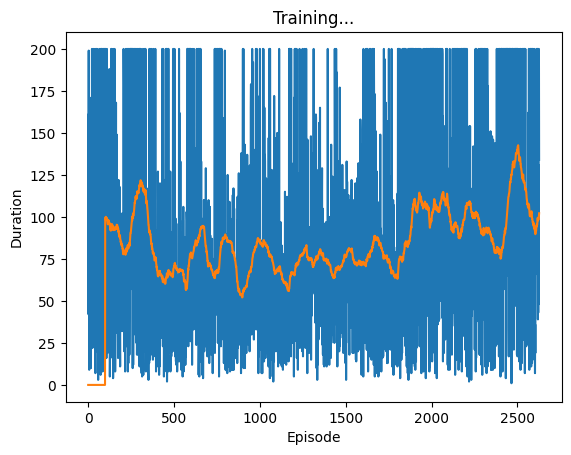

<Figure size 640x480 with 0 Axes>

In [ ]:
if __name__ == "__main__":
    # Environment setup
    env = SectorCREnvironment(render_mode='human')
    env.env.action_space.seed(SEED)

    # Get state dimensions
    initial_state = env.reset()
    n_observations = initial_state.shape[-1]
    n_bins_per_dim = env.n_bins_per_dim

    # Initialize Q-network
    Q_network = QNetwork(n_observations, n_bins_per_dim, n_bins_per_dim).to(device)
    optimizer = optim.AdamW(Q_network.parameters(), lr=1e-4, amsgrad=True)

    # Hyperparameters
    episodes = 600 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50
    alpha = 1e-4  # Learning rate (handled by optimizer)
    gamma = 0.99
    epsilon_start = 0.9
    epsilon_end = 0.01
    epsilon_decay = 5000

    print("Starting SARSA Training...")
    print(f"Device: {device}")
    print(f"Episodes: {episodes}")
    print(f"State dimensions: {n_observations}")
    print(f"Action bins: {n_bins_per_dim} x {n_bins_per_dim}")

    # Train using SARSA
    Q_network, episode_durations, episode_rewards, episode_losses = sarsa(
        env, Q_network, optimizer, episodes, alpha, gamma,
        epsilon_start, epsilon_end, epsilon_decay
    )

    print("Training Complete!")
    print(f"Total episodes: {episodes}")

    # Print loss statistics
    if len(episode_losses) > 0:
        print(f"\nLoss Statistics:")
        print(f"  First episode average loss: {episode_losses[0]:.4f}")
        print(f"  Final episode average loss: {episode_losses[-1]:.4f}")
        if len(episode_losses) >= 50:
            avg_last_50 = np.mean(episode_losses[-50:])
            print(f"  Average loss over last 50 episodes: {avg_last_50:.4f}")
        if len(episode_losses) >= 100:
            avg_last_100 = np.mean(episode_losses[-100:])
            print(f"  Average loss over last 100 episodes: {avg_last_100:.4f}")
        print(f"  Overall average loss: {np.mean(episode_losses):.4f}")


    # Plot rewards separately
    reward_array = np.array([r if not torch.is_tensor(r) else r for r in episode_rewards])
    reward_avg = np.convolve(reward_array, np.ones(20)/20, mode='valid')
    plt.plot(reward_avg)
    plt.title('Episode Rewards (20-episode moving average)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    # Visualization: Run trained policy
    print("\nRunning trained policy visualization...")
    env_visual = SectorCREnvironment(render_mode='human')
    num_episodes_to_visualize = 5

    viz_steps = []
    viz_rewards = []

    for episode in range(num_episodes_to_visualize):
        state = env_visual.reset()
        total_reward = 0
        episode_loss = []
        done = False
        steps = 0

        while not done:
            # Greedy policy (no exploration)
            with torch.no_grad():
                heading_q, speed_q = Q_network(state)
                heading_action = heading_q.max(1).indices.view(1, 1)
                speed_action = speed_q.max(1).indices.view(1, 1)

            state, reward, done = env_visual.step(heading_action, speed_action)
            total_reward += reward
            steps += 1

        viz_steps.append(steps)
        viz_rewards.append(total_reward)
        print(f"Visualization Episode {episode + 1}: Steps = {steps}, Total Reward = {total_reward:.2f}")

    # Calculate and print statistics
    print("Visualization Statistics (5 episodes):")
    print(f"  Average Steps: {np.mean(viz_steps):.2f} ± {np.std(viz_steps):.2f}")
    print(f"  Average Reward: {np.mean(viz_rewards):.2f} ± {np.std(viz_rewards):.2f}")

    env_visual.close()
